In [2]:
import numpy as np
from joblib import Parallel, delayed
import multiprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
import pandas as pd

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set()

In [5]:
from mpl_toolkits import mplot3d
import json

#Agenda

#What is Machine Learning

###Machine Learning is a sub-field of computer science that utilizes computational statistics and mathematical optimization to develop algorithms that can identify useful patterns from data.

###While statisticians are more concerned with developing intrepretable models with a strong theoretical foundation, machine learning practioners are more concerned with developing predictive models.

###With the advent of Big Data, machine learning is also concerned with scaling up algorithms to perform well on larger datasets and developing new methodolgy to deal with large datasets.

#About DrivenData

In [6]:
from IPython.display import VimeoVideo, Image, Latex

### DrivenData is a social enterprise that harnesses data science for social good. By identifying where cutting edge tools and techniques can make the greatest impact, and then framing these opportunities in a way that engages a global community of experts, DrivenData connects nonprofits with talent that would otherwise be too expensive or difficult to find. The bridge we build between impact organizations and data scientists creates powerful new solutions that can revolutionize the way the social and public sectors uses their data.​

In [54]:
VimeoVideo("99284987", width = 600, height = 450)

#Dataset

##The dataset we'll be working with comes from DrivenData's [Warm Up: Predict Blood Donations](http://www.drivendata.org/competitions/2/page/5/).

##For this problem, we are interested in predicting whether an individual donated blood in March 2007.

##For each individual, we have the following information:
- **Months since Last Donation**: Number of months since a donor's most recent donation.
- **Number of Donations**: Number of times this donor has given blood.
- **Total Volumn Donated**: Total volume of blood donated in cubic centimeters (cc).
- **Months since First Donation**: Number of months since a donor's first donation.

### In the training set, we have 578 records.

In [9]:
training = np.loadtxt("training.csv", delimiter=",", skiprows =1)
training_ids = training[:,0]
training_X = training[:,1:-1]
training_y = training[:,-1].astype(int)

### In the testing set, we have 200 records.

In [10]:
testing = np.loadtxt("testing.csv", delimiter=",", skiprows = 1)
test_ids, testing = testing[:,0], testing[:,1:]

In [11]:
training_X.shape, testing.shape

((576, 4), (200, 4))

#Exploratory Data Analysis

In [12]:
training_set = pd.read_csv('training.csv', delimiter=',')
variables = training_set.columns[1:-1].tolist()

In [13]:
num_0s = sum(training_y == 0)
num_1s = sum(training_y)
print "Number of non-doners in March 2007: %d" % num_0s
print "Number of doners in March 2007: %d" % num_1s

Number of non-doners in March 2007: 438
Number of doners in March 2007: 138


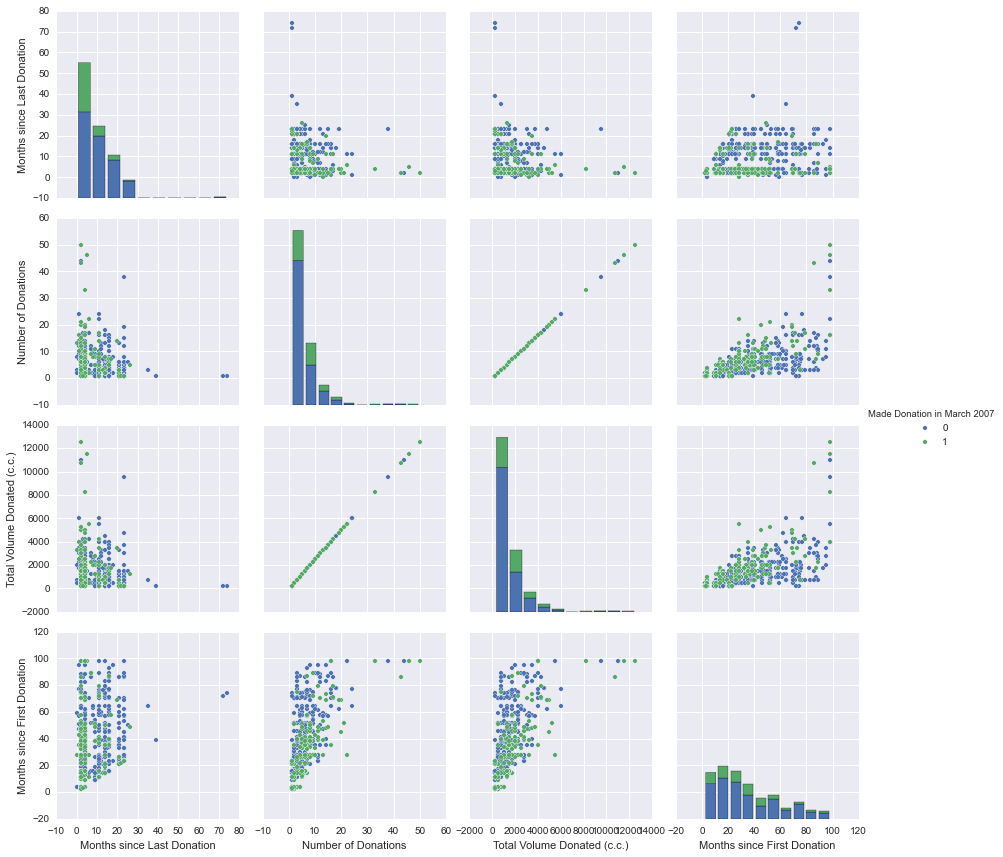

In [14]:
sns.pairplot(training_set, hue = 'Made Donation in March 2007', vars = variables, size = 3.0)

If we look at the pair plot, we notice some obvious patterns:
- Number of Donations and Total Volume Donated are linearly correlated.
- For months since last donation, donors are clustered near the lower-left corner.

#Machine Learning Models

###To evaluate our models, we will use the Log Loss metric for binary classification.

In [75]:
Latex(r"""\begin{eqnarray}
\text{Log Loss} = - \frac{1}{n} \sum_{i=1} ^n [y_i log(\hat{y_i}) + (1-y_i) log(1 - \hat{y_i})]
\end{eqnarray}""")

<IPython.core.display.Latex object>

###The Log Loss metric assigns a steep penalty to predictions that are confident and wrong.

#First, let's start with something simple

In [23]:
clf = KNeighborsClassifier(n_neighbors = 5)
clf.fit(training_X_t, training_y)
probabilities = clf.predict_proba(testing_t)
prob_donate_adaboost = probabilities[:,0]
print "The Log Loss for the K-Neighbors classifier is %0.2f" % (metrics.log_loss(training_y, clf.predict_proba(training_X_t)))

The Log Loss for the K-Neighbors classifier is 0.53


##Next, let's try Logistic Regresion

In [24]:
params_reg = {'penalty':['l1','l2'], 'C':[0.1,1]}
logreg = LogisticRegression()
clf = GridSearchCV(logreg, params_reg, n_jobs = -1)
clf.fit(training_X_t, training_y)
probabilities = clf.predict_proba(testing_t)
prob_donate_reg = probabilities[:, 0]
print "The Log Loss for the Logistic Regression classifier is %0.2f" % (metrics.log_loss(training_y, clf.predict_proba(training_X_t)))

The Log Loss for the Logistic Regression classifier is 0.49


##Finally, let's use something a little bit more advanced

In [50]:
clf = SVC(kernel = 'rbf', C = 0.5, probability = True, random_state = 249, class_weight = "auto")
clf.fit(training_X_t, training_y)
probabilities = clf.predict_proba(testing_t)
prob_donate_svc = probabilities[:,0]
print "The Log Loss for the Support Vector Machine classifier is %0.2f" % (metrics.log_loss(training_y, clf.predict_proba(training_X_t)))

The Log Loss for the Support Vector Machine classifier is 0.39


##Of our three models, the Support Vector Machine seems to perform the best. Let's make a submission.

In [56]:
output = open("results/submission.csv", "w+")
output.write(',Made Donation in March 2007\n')

for idx, donate_prob in zip(test_ids, prob_donate_svc):
	output.write("%s, %0.2f\n" % (int(idx), donate_prob))
output.close()

#Examining Errors

In [35]:
def analyzeErrors(y_true, y_pred, title = "Confusion Matrix", cmap = plt.cm.Blues):
    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    plt.imshow(conf_matrix, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len([0,1]))
    plt.xticks(tick_marks,["Non-Donor", "Donor"])
    plt.yticks(tick_marks,["Non-Donor", "Donor"])
    plt.tight_layout()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

In [51]:
y_pred = clf.predict(training_X_t)

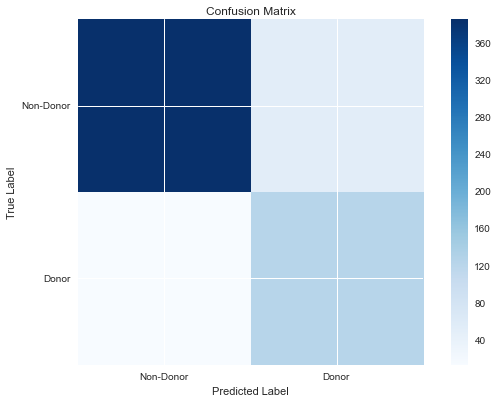

In [52]:
analyzeErrors(training_y, y_pred)

In [53]:
print metrics.confusion_matrix(training_y, y_pred)

[[386  52]
 [ 14 124]]


In [43]:
def visualizeErrors(clf, data, x_var, y_var, labels, h = 1.5, boundaries = True, xlim = None, ylim = None):
    x_min, x_max = data[:, x_var].min() - 1, data[:, x_var].max() + 1
    y_min, y_max = data[:, y_var].min() - 1, data[:, y_var].max() + 1


    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap='rainbow', alpha = 0.2)

    # Plot also the training points
    plt.scatter(data[:, x_var], data[:, y_var], c=labels, cmap='rainbow', s = 40)

    plt.colorbar(ticks=[0, 1])
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel("PCA Feature %d" %(x_var+1))
    plt.ylabel("PCA Feature %d" % (y_var+1));

In [54]:
x_var = 0
y_var = 1

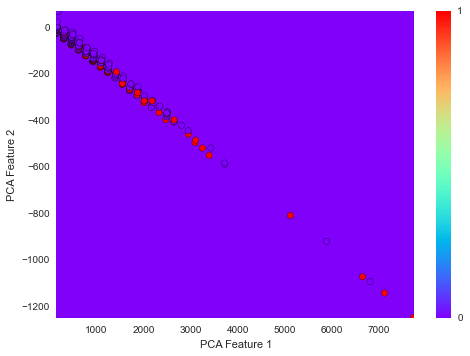

In [55]:
visualizeErrors(clf, training_X_t, x_var, y_var, training_y)

#Improving the Model

##Although we have only 4 features, could we possibly use fewer features?

In [7]:
from sklearn import feature_selection

In [62]:
F, pval = feature_selection.f_classif(training_X, training_y)

In [65]:
for i,(f_sc, p_val) in enumerate(zip(F, pval)):
    print "Feature %d has a F-score of %0.2f with a corresponding p-value of %0.3f" % (i, f_sc, p_val)

Feature 0 has a F-score of 42.04 with a corresponding p-value of 0.000
Feature 1 has a F-score of 29.37 with a corresponding p-value of 0.000
Feature 2 has a F-score of 29.37 with a corresponding p-value of 0.000
Feature 3 has a F-score of 0.23 with a corresponding p-value of 0.635


###According to the ANOVA feature selection test, the last feature (Months since first donation) does not appear to be statistically significant in prediction blood donation in March 2007. Using the three significant features, we get a distribution that looks like this.

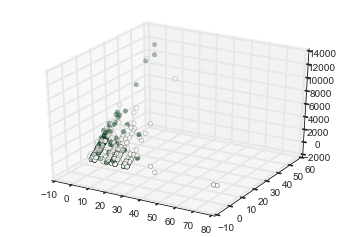

In [67]:
ax = plt.axes(projection = "3d")
ax.scatter3D(training_X[:,0], training_X[:,1], training_X[:,2], c = training_y, cmap = 'Greens')

###Let's remove the "Months Since First Donation" feature and see if our model performs better.

In [125]:
training_X = training_X[:,:3]
testing = testing[:,:3]
print training_X.shape, testing.shape

(576, 3) (200, 3)


##Let's use PCA instead

In [8]:
from sklearn import preprocessing
from sklearn.decomposition import RandomizedPCA

###Before we can apply PCA, we need to "whiten" the dataset. To do this, we standarize each feature by subtracting the mean and dividing by the standard deviation.

In [20]:
standarization = preprocessing.StandardScaler()
training_X_t = standarization.fit_transform(training_X)
testing_t = standarization.transform(testing)

###Principal Component Analysis is a dimensionality reduction algorithm that projects the data to a lower-dimensional space that best captures the variance in the original dataset.

In [21]:
pca = RandomizedPCA(n_components = 2)
pca.fit(training_X_t)
print pca.explained_variance_ratio_

[ 0.62971882  0.27842014]


###By using the first two eigenvectors, we can retain 90% of the explained variance.

In [22]:
training_X_t = pca.transform(training_X)
testing_t = pca.transform(testing)

#Scaling Up: Mo' Data, Mo' Problems

## Parallelization is your friend.

In [58]:
all_cores = multiprocessing.cpu_count()
print "There are %d cores available" % all_cores

There are 4 cores available


In [63]:
from matplotlib.path import Path

all_segments = zip(np.random.rand(5000,2), np.random.rand(5000,2))
test_segments = zip(np.random.rand(200,2), np.random.rand(200,2))

In [60]:
def check_paths(path):
    for other_path in all_segments:
        res = "Did not cross"
        chk = Path(other_path)
        if chk.contains_path(path) == 1:
            res = "Crossed"
            break
        return res

In [68]:
%time res = Parallel(n_jobs = -1) (delayed(check_paths) (Path(test_segment)) for test_segment in test_segments)

CPU times: user 129 ms, sys: 35.9 ms, total: 165 ms
Wall time: 195 ms


In [69]:
%time res = Parallel(n_jobs = 1) (delayed(check_paths) (Path(test_segment)) for test_segment in test_segments)

CPU times: user 9.56 ms, sys: 2.51 ms, total: 12.1 ms
Wall time: 10.3 ms


#The Problem with Leaderboards

## This section is based on Moritz Hardt's [Competing in a Data Science contest without reading the data](http://blog.mrtz.org/2015/03/09/competition.html)

##Because competition sites like Kaggle and DrivenData use a leaderboard with a holdout test set, users may sometimes incorporate feedback from the leaderboard to boost the performance of their model.

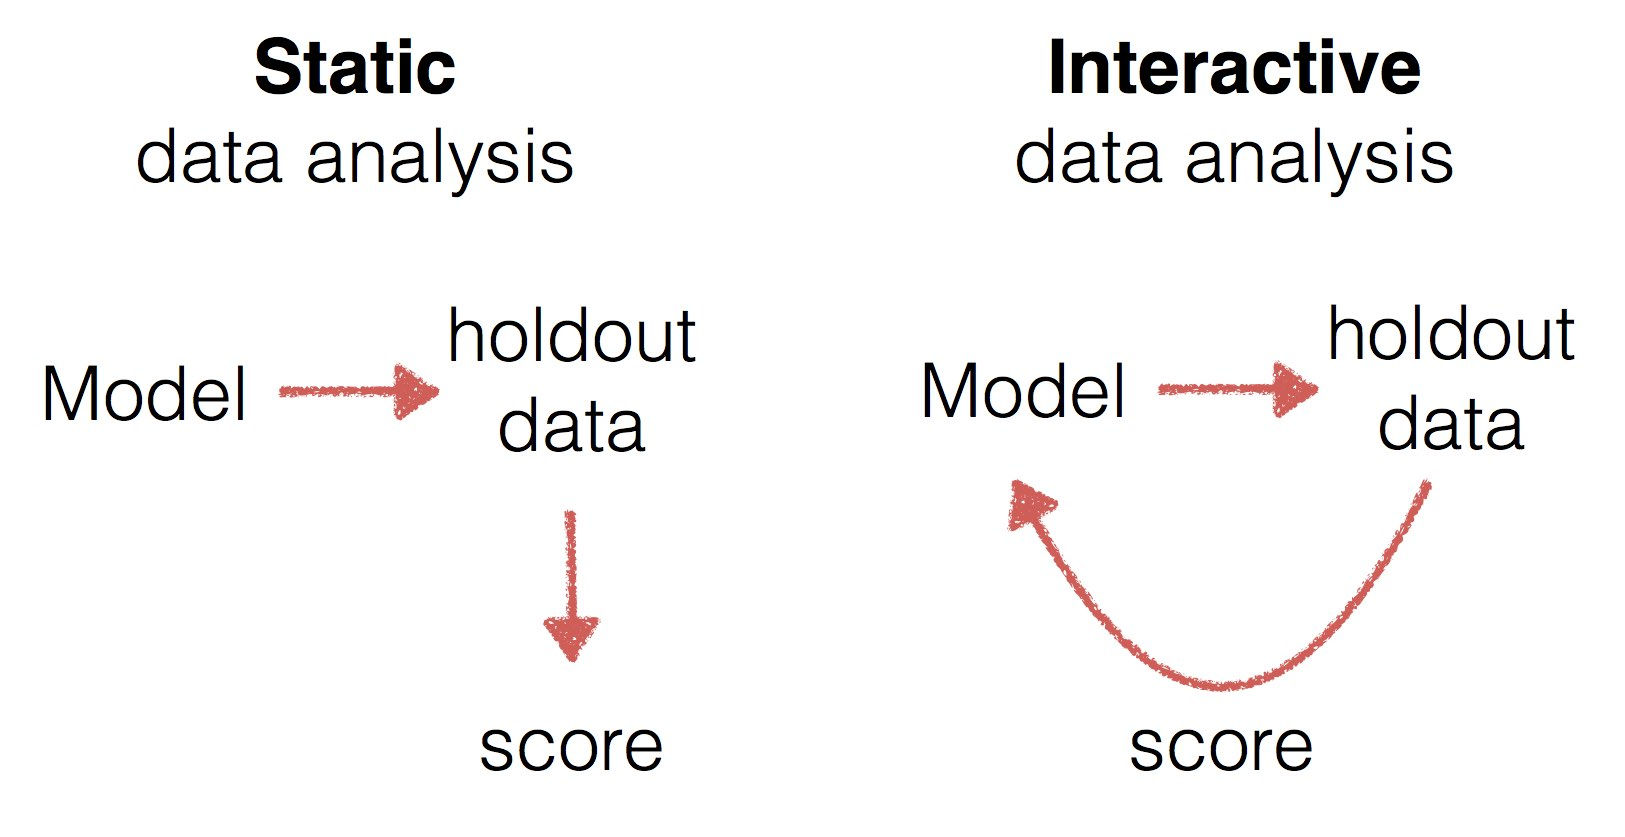

In [81]:
Image('http://blog.mrtz.org/assets/staticvsint.jpg', width = 800, height = 300)

##There is a big problem here! There are two leaderboards: the public leaderboard and the private leaderboard. Competitors see only the results of the public leaderboard, so by incorporating feedback from the public leaderboard, their models overfit and perform poorly on the private leaderboard.

##In his post, Hardt showed that one could game the leaderboard without even using the dataset. He "proposes" a Wacky Boosting Algorithm:
- 1.) Create K random submissions of labels.
- 2.) Keep the "good" submissions that achieve an error/misclassification rate of less than 0.5
- 3.) Create a final submission composed of majority voting of the "good" submissions.